In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath("__file__")))

import time 
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import CLIPTokenizerFast

from src_emotion.datasets.dataset_video_retrieval import (
    HDVILAVideoRetrievalDataset, VideoRetrievalCollator)

from src_emotion.configs.config import shared_configs
from src_emotion.utils.misc import set_random_seed
from src_emotion.utils.logger import LOGGER
from src_emotion.utils.load_save import load_state_dict_with_mismatch
from src_emotion.utils.emotion_utils import encode_query

from src_emotion.utils.metrics import cal_cossim

# README
* Not using havarod library but cuda
* 

In [2]:
def mk_video_ret_dataloader(dataset_name, vis_format, anno_path, vis_dir, cfg, tokenizer, mode):
    is_train = mode == "train"
    dataset = HDVILAVideoRetrievalDataset(
        cfg=cfg,
        vis_dir=vis_dir,
        anno_path=anno_path,
        vis_format=vis_format,
        mode=mode
    )
    LOGGER.info(f"[{dataset_name}] is_train {is_train} "
                f"dataset size {len(dataset)}, ")

    batch_size = cfg.train_batch_size if is_train else cfg.test_batch_size
    vret_collator = VideoRetrievalCollator(
        tokenizer=tokenizer, max_length=cfg.max_txt_len, is_train=is_train)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=cfg.n_workers,
                            pin_memory=cfg.pin_mem,
                            collate_fn=vret_collator.collate_batch)
    return dataloader


def setup_model(cfg, device=None):
    LOGGER.info("Setup model...")
    
    if cfg.is_embed:
        from src_emotion.modeling.VidCLIP import VidCLIP
        model = VidCLIP(cfg)
    else:
        from src.modeling.VidCLIP import VidCLIP
        model = VidCLIP(cfg)

    if cfg.e2e_weights_path:
        LOGGER.info(f"Loading e2e weights from {cfg.e2e_weights_path}")
        
        load_state_dict_with_mismatch(model, cfg.e2e_weights_path)
    
    if hasattr(cfg, "overload_logit_scale"):
        model.overload_logit_scale(cfg.overload_logit_scale)
    
    model.to(device)

    LOGGER.info("Setup model done!")
    return model

# Arguments

* script 파일(.py)는 dummy script일 뿐이라서 아래의 config 에서 활용되지 않음. 즉, 무시해도 됨.
* script 파일(.py) 이후의 arguments 들만 아래의 셀들에서 활용됨.

### Baseline Model

In [3]:
sys.argv = ['src/tasks/run_video_retrieval.py', '--config', './src_emotion/configs/msrvtt_retrieval/tsne_retrieval_vip_base_32.json',
            '--query', 'There are many people happy']
cfg_base = shared_configs.parse_args()
cfg_base.e2e_weights_path = cfg_base.base_e2e_weights_path # overwrite the weight path
cfg_base.is_embed = False
cfg_base.is_demo = False
# cfg_base.emotion = encode_query(cfg_base.query, None)

### Emotion Embedding Model

In [4]:
sys.argv = ['src/tasks/run_video_retrieval.py', '--config', './src_emotion/configs/msrvtt_retrieval/tsne_retrieval_vip_base_32.json',
            '--query', 'There are many people happy']
cfg_embed = shared_configs.parse_args()
cfg_embed.is_embed = True
cfg_embed.is_demo = False
# cfg_embed.emotion = encode_query(cfg_embed.query, None)

# Load Test Data

In [5]:
set_random_seed(cfg_base.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data for base model
tokenizer = CLIPTokenizerFast.from_pretrained(cfg_base.clip_config)
base_val_loaders = {}
for db in cfg_base.val_datasets:
    base_val_loaders[db.name] = mk_video_ret_dataloader(
        dataset_name=db.name, vis_format=db.vis_format,
        anno_path=db.txt, vis_dir=db.vis,
        cfg=cfg_base, tokenizer=tokenizer, mode="test"
    )

base_inference_loaders = {}
for db in cfg_base.inference_datasets:
    base_inference_loaders[db.name] = mk_video_ret_dataloader(
        dataset_name=db.name, vis_format=db.vis_format,
        anno_path=db.txt, vis_dir=db.vis,
        cfg=cfg_base, tokenizer=tokenizer, mode="test"
    )

# data for emotion embed model
tokenizer = CLIPTokenizerFast.from_pretrained(cfg_embed.clip_config)
embed_val_loaders = {}
for db in cfg_embed.val_datasets:
    embed_val_loaders[db.name] = mk_video_ret_dataloader(
        dataset_name=db.name, vis_format=db.vis_format,
        anno_path=db.txt, vis_dir=db.vis,
        cfg=cfg_base, tokenizer=tokenizer, mode="test"
    )

embed_inference_loaders = {}
for db in cfg_embed.inference_datasets:
    embed_inference_loaders[db.name] = mk_video_ret_dataloader(
        dataset_name=db.name, vis_format=db.vis_format,
        anno_path=db.txt, vis_dir=db.vis,
        cfg=cfg_embed, tokenizer=tokenizer, mode="test"
    )

03/30/2024 11:11:17 - INFO - __main__ -   [demo-val] is_train False dataset size 1000, 
03/30/2024 11:11:17 - INFO - __main__ -   [demo-test] is_train False dataset size 1000, 
03/30/2024 11:11:17 - INFO - __main__ -   [demo-val] is_train False dataset size 1000, 
03/30/2024 11:11:17 - INFO - __main__ -   [demo-test] is_train False dataset size 1000, 


# Evaluate the Base Model and Emotion Embedding Model

In [6]:
# base model
base_model = setup_model(cfg_base, device=device)
base_model.eval()

# emotion embed model
embed_model = setup_model(cfg_embed, device=device)
embed_model.eval()

03/30/2024 11:11:20 - INFO - __main__ -   Setup model...
Some weights of CLIPModel were not initialized from the model checkpoint at openai/clip-vit-base-patch32 and are newly initialized: ['vision_model.embeddings.added_cls', 'vision_model.embeddings.temporal_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
03/30/2024 11:11:21 - INFO - __main__ -   Loading e2e weights from ./saved_models/base_model_best_msrvtt7k_b64.pt
03/30/2024 11:11:21 - INFO - __main__ -   You can ignore the keys with `num_batches_tracked` or from task heads
03/30/2024 11:11:21 - INFO - __main__ -   Keys in loaded but not in model:
03/30/2024 11:11:21 - INFO - __main__ -   In total 0, []
03/30/2024 11:11:21 - INFO - __main__ -   Keys in model but not in loaded:
03/30/2024 11:11:21 - INFO - __main__ -   In total 0, []
03/30/2024 11:11:21 - INFO - __main__ -   Keys in model and loaded, but shape mismatched:
03/30/2024 11:11:21 - INFO - __main_

VidCLIP(
  (clipmodel): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
        (emotion_embedding): Embedding(8, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0): CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features

# T-SNE Embedding Space Visualization

In [220]:
# t-sne visualization
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [221]:
emotion_list = [
    "joy",
    "trust",
    "fear",
    "surprise",
    "sadness",
    "disgust",
    "anger",
    "anticipation"
]

In [13]:
emotion_ids = []
embed_vis_feats = []
embed_text_feats = []
base_vis_feats = []
base_text_feats = []

with torch.no_grad():
    for data in base_val_loaders['demo-val']:        
        emotion_ids.extend(np.argmax(data['emotions'].cpu().numpy(), axis=1))
        data['video'] = data['video'].to(device)
        data['text_input_ids'] = data['text_input_ids'].to(device)
        data['text_input_mask'] = data['text_input_mask'].to(device)
        data['emotions'] = data['emotions'].to(device)
        
        # embed model
        embed_output = embed_model(**data)
        embed_vis_feats.append(embed_output['vis_features'].cpu().numpy())
        embed_text_feats.append(embed_output['text_features'].cpu().numpy())
        
        # base model
        del data['emotions']
        base_output = base_model(**data)
        base_vis_feats.append(base_output['vis_features'].cpu().numpy())
        base_text_feats.append(base_output['text_features'].cpu().numpy())

In [22]:
embed_vis_feats = np.vstack(embed_vis_feats)
embed_text_feats = np.vstack(embed_text_feats)

base_vis_feats = np.vstack(base_vis_feats)
base_text_feats = np.vstack(base_text_feats)

In [35]:
tsne = TSNE(n_components=2, perplexity=5)

base_feats = np.vstack([base_vis_feats, base_text_feats])
embed_feats = np.vstack([embed_vis_feats, embed_text_feats])

In [33]:
vis_labels = [emotion_list[i] for i in emotion_ids]

# each emotion label
joy_labels = ['Joy' if label == 'joy' else 'Non-Joy' for label in vis_labels]
trust_labels = ['Trust' if label == 'trust' else 'Non-Trust' for label in vis_labels]
fear_labels = ['Fear' if label == 'fear' else 'Non-Fear' for label in vis_labels]
surprise_labels = ['Surprise' if label == 'surprise' else 'Non-Surprise' for label in vis_labels]
sadness_labels = ['Sadness' if label == 'sadness' else 'Non-Sadness' for label in vis_labels]
disgust_labels = ['Disgust' if label == 'disgust' else 'Non-Disgust' for label in vis_labels]
anger_labels = ['Anger' if label == 'anger' else 'Non-Anger' for label in vis_labels]
anticipation_labels = ['Anticipation' if label == 'anticipation' else 'Non-Anticipation' for label in vis_labels]

# Visualization One vs. Non

In [158]:
# visualize
base_tsne = tsne.fit_transform(base_feats)
feat_len = len(base_vis_feats)

embed_tsne = tsne.fit_transform(embed_feats)
feat_len = len(embed_vis_feats)

In [311]:
def visualize_tsne(base_tsne, embed_tsne, emotion_label, fig_save_dir, is_save=False, is_show=True):
    # create dataframe
    base_tsne_df = pd.DataFrame(base_tsne, columns=["X1", "X2"])
    base_tsne_df['Emotion'] = emotion_label * 2
    base_tsne_df['Encoder'] = ['Video'] * 1000 + ['Text'] * 1000
    embed_tsne_df = pd.DataFrame(embed_tsne, columns=["X1", "X2"])
    embed_tsne_df['Emotion'] = emotion_label * 2
    embed_tsne_df['Encoder'] = ['Video'] * 1000 + ['Text'] * 1000
    
    label = sorted(set(emotion_label), key=lambda x: len(x))
    
    # Base TSNE plot
    plt.figure(figsize=(10, 10))
    plt.title('T-SNE Visualization: {} vs {}'.format(label[0], label[1]))
    ax = sns.scatterplot(data=base_tsne_df, x='X1', y='X2', hue='Emotion', style='Encoder')
    
    # Custom legend handling with modified labels
    handles, labels = ax.get_legend_handles_labels()
    modified_labels = ['<Emotion>' if l == 'Emotion' else '<Encoder>' if l == 'Encoder' else l for l in labels]
    plt.legend(handles=handles, labels=modified_labels)
    
    plt.tight_layout()
    if is_save:
        plt.savefig(fig_save_dir + 'base_tsne_{}.png'.format(label[0]))
        print('Save figure', 'base_tsne_{}.png'.format(label[0]))
    if is_show:
        plt.show()
    
    # Embed TSNE plot
    plt.figure(figsize=(10, 10))
    plt.title('T-SNE Visualization: {} vs {}'.format(label[0], label[1]))
    ax = sns.scatterplot(data=embed_tsne_df, x='X1', y='X2', hue='Emotion', style='Encoder')
    
    # Repeat custom legend handling for the second plot with modified labels
    handles, labels = ax.get_legend_handles_labels()
    modified_labels = ['<Emotion>' if l == 'Emotion' else '<Encoder>' if l == 'Encoder' else l for l in labels]
    plt.legend(handles=handles, labels=modified_labels)
    
    plt.tight_layout()
    if is_save:
        plt.savefig(fig_save_dir + 'embed_tsne_{}.png'.format(label[0]))
        print('Save figure', 'embed_tsne_{}.png'.format(label[0]))
    if is_show:
        plt.show()

       
def visualize_tsne_each_color(base_tsne, embed_tsne, emotion_label, fig_save_dir, is_save=False, is_show=True):
    # create dataframe
    base_tsne_df = pd.DataFrame(base_tsne, columns=["X1", "X2"])
    video_labels = [label+' Video'  for label in emotion_label]
    text_labels = [label+' Text' for label in emotion_label]
    base_tsne_df['Encoder'] = video_labels + text_labels
    embed_tsne_df = pd.DataFrame(embed_tsne, columns=["X1", "X2"])
    embed_tsne_df['Encoder'] = video_labels + text_labels
    
    label = sorted(set(emotion_label), key=lambda x: len(x))
    
    # TSNE plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    plt.suptitle('T-SNE Visualization: {} vs {}'.format(label[0], label[1]), fontsize=20)
    sns.scatterplot(ax=axes[0], data=base_tsne_df, x='X1', y='X2', hue='Encoder')
    axes[0].set_title('Baseline Model', fontsize=15)
    axes[0].legend(loc='upper right', fontsize=12).set_title('Embedding Type', prop={'size': 12})
    axes[0].set_xlabel('X1', fontsize=15)
    axes[0].set_ylabel('X2', fontsize=15)
    axes[0].xaxis.set_tick_params(labelsize=15)
    axes[0].yaxis.set_tick_params(labelsize=15)
    
    sns.scatterplot(ax=axes[1], data=embed_tsne_df, x='X1', y='X2', hue='Encoder')
    axes[1].set_title('Our Model', fontsize=15)
    axes[1].legend(loc='upper right', fontsize=12).set_title('Embedding Type', prop={'size': 12})
    axes[1].set_xlabel('X1', fontsize=15)
    axes[1].set_ylabel('X2', fontsize=15)
    axes[1].xaxis.set_tick_params(labelsize=15)
    axes[1].yaxis.set_tick_params(labelsize=15)

    plt.tight_layout()

    # save figure
    if is_save:
        plt.savefig(fig_save_dir + 'tsne_{}.png'.format(label[0]))
        print('Save figure', 'tsne_{}.png'.format(label[0]))
    if is_show:
        plt.show()
    else:
        plt.close()
    
    
def visualize_tsne_emotion_color(base_tsne, embed_tsne, emotion_label, fig_save_dir, is_save=False, is_show=True):
    # set unique color for each emotion
    unique_emotions = sorted(set(emotion_label))
    colors = sns.color_palette('deep', len(unique_emotions))

    # adjust color by brightness and saturation
    def adjust_color(color, factor=1.1):
        rgb = mcolors.to_rgb(color)
        adjusted = tuple(min(1, c * factor) for c in rgb)
        return adjusted

    # create palette
    palette = {}
    for emotion, color in zip(unique_emotions, colors):
        palette[emotion + ' Video'] = color
        adjusted_color = adjust_color(color, factor=1.3)  # adjust color for emotion
        palette[emotion + ' Text'] = adjusted_color
        
    # create dataframe
    base_tsne_df = pd.DataFrame(base_tsne, columns=["X1", "X2"])
    video_labels = [label+' Video'  for label in emotion_label]
    text_labels = [label+' Text' for label in emotion_label]
    base_tsne_df['Encoder'] = video_labels + text_labels
    embed_tsne_df = pd.DataFrame(embed_tsne, columns=["X1", "X2"])
    embed_tsne_df['Encoder'] = video_labels + text_labels
    
    label = sorted(set(emotion_label), key=lambda x: len(x))
    
    # TSNE plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    plt.suptitle('T-SNE Visualization: {} vs {}'.format(label[0], label[1]), fontsize=20)
    sns.scatterplot(ax=axes[0], data=base_tsne_df, x='X1', y='X2', hue='Encoder', palette=palette)
    axes[0].set_title('Baseline Model', fontsize=15)
    axes[0].legend(loc='upper right', fontsize=12).set_title('Embedding Type', prop={'size': 12})
    axes[0].set_xlabel('X1', fontsize=15)
    axes[0].set_ylabel('X2', fontsize=15)
    axes[0].xaxis.set_tick_params(labelsize=15)
    axes[0].yaxis.set_tick_params(labelsize=15)
    
    sns.scatterplot(ax=axes[1], data=embed_tsne_df, x='X1', y='X2', hue='Encoder', palette=palette)
    axes[1].set_title('Our Model', fontsize=15)
    axes[1].legend(loc='upper right', fontsize=12).set_title('Embedding Type', prop={'size': 12})
    axes[1].set_xlabel('X1', fontsize=15)
    axes[1].set_ylabel('X2', fontsize=15)
    axes[1].xaxis.set_tick_params(labelsize=15)
    axes[1].yaxis.set_tick_params(labelsize=15)

    plt.tight_layout()

    # save figure
    if is_save:
        plt.savefig(fig_save_dir + 'tsne_{}.png'.format(label[0]))
        print('Save figure', 'tsne_{}.png'.format(label[0]))
    if is_show:
        plt.show()
    else:
        plt.close()

## Visualization 4 color:  each embedding type for each color

In [313]:
emotion_labels = [joy_labels, trust_labels, fear_labels, surprise_labels, sadness_labels, disgust_labels, anger_labels, anticipation_labels]
fig_save_dir = './final_report/tsne/each_color/'

In [314]:
for label in emotion_labels:
    visualize_tsne_each_color(base_tsne, embed_tsne, label, fig_save_dir, is_save=True, is_show=False)

Save figure tsne_Joy.png
Save figure tsne_Trust.png
Save figure tsne_Fear.png
Save figure tsne_Surprise.png
Save figure tsne_Sadness.png
Save figure tsne_Disgust.png
Save figure tsne_Anger.png
Save figure tsne_Anticipation.png


## Visualization 2 color: each emotion type for each color

In [315]:
emotion_labels = [joy_labels, trust_labels, fear_labels, surprise_labels, sadness_labels, disgust_labels, anger_labels, anticipation_labels]
fig_save_dir = './final_report/tsne/emotion_color/'

In [316]:
for label in emotion_labels:
    visualize_tsne_emotion_color(base_tsne, embed_tsne, label, fig_save_dir, is_save=True, is_show=False)

Save figure tsne_Joy.png
Save figure tsne_Trust.png
Save figure tsne_Fear.png
Save figure tsne_Surprise.png
Save figure tsne_Sadness.png
Save figure tsne_Disgust.png
Save figure tsne_Anger.png
Save figure tsne_Anticipation.png


## Matplotlib

In [216]:
# visualize
base_tsne = tsne.fit_transform(base_feats)
feat_len = len(base_vis_feats)

base_vis_tsne = base_tsne[:len(base_vis_feats)]
base_text_tsne = base_tsne[len(base_vis_feats):]

embed_tsne = tsne.fit_transform(embed_feats)
feat_len = len(embed_vis_feats)

embed_vis_tsne = embed_tsne[:len(embed_vis_feats)]
embed_text_tsne = embed_tsne[len(embed_vis_feats):]

In [217]:
# select angry index
joy_idx, joy_rest_idx = [i for i, label in enumerate(vis_labels) if label == 'joy'], [i for i, label in enumerate(vis_labels) if label != 'joy']
trust_idx, trust_rest_idx = [i for i, label in enumerate(vis_labels) if label == 'trust'], [i for i, label in enumerate(vis_labels) if label != 'trust']
fear_idxj, fear_rest_idx = [i for i, label in enumerate(vis_labels) if label == 'fear'], [i for i, label in enumerate(vis_labels) if label != 'fear']
surprise_idx, surprise_rest_idx = [i for i, label in enumerate(vis_labels) if label == 'surprise'], [i for i, label in enumerate(vis_labels) if label != 'surprise']
sadness_idx, sadness_rest_idx = [i for i, label in enumerate(vis_labels) if label == 'sadness'], [i for i, label in enumerate(vis_labels) if label != 'sadness']
disgust_idx, disgust_rest_idx = [i for i, label in enumerate(vis_labels) if label == 'disgust'], [i for i, label in enumerate(vis_labels) if label != 'disgust']
anger_idx, anger_rest_idx = [i for i, label in enumerate(vis_labels) if label == 'anger'], [i for i, label in enumerate(vis_labels) if label != 'anger']
anticipation_idx, anticipation_rest_idx = [i for i, label in enumerate(vis_labels) if label == 'anticipation'], [i for i, label in enumerate(vis_labels) if label != 'anticipation']

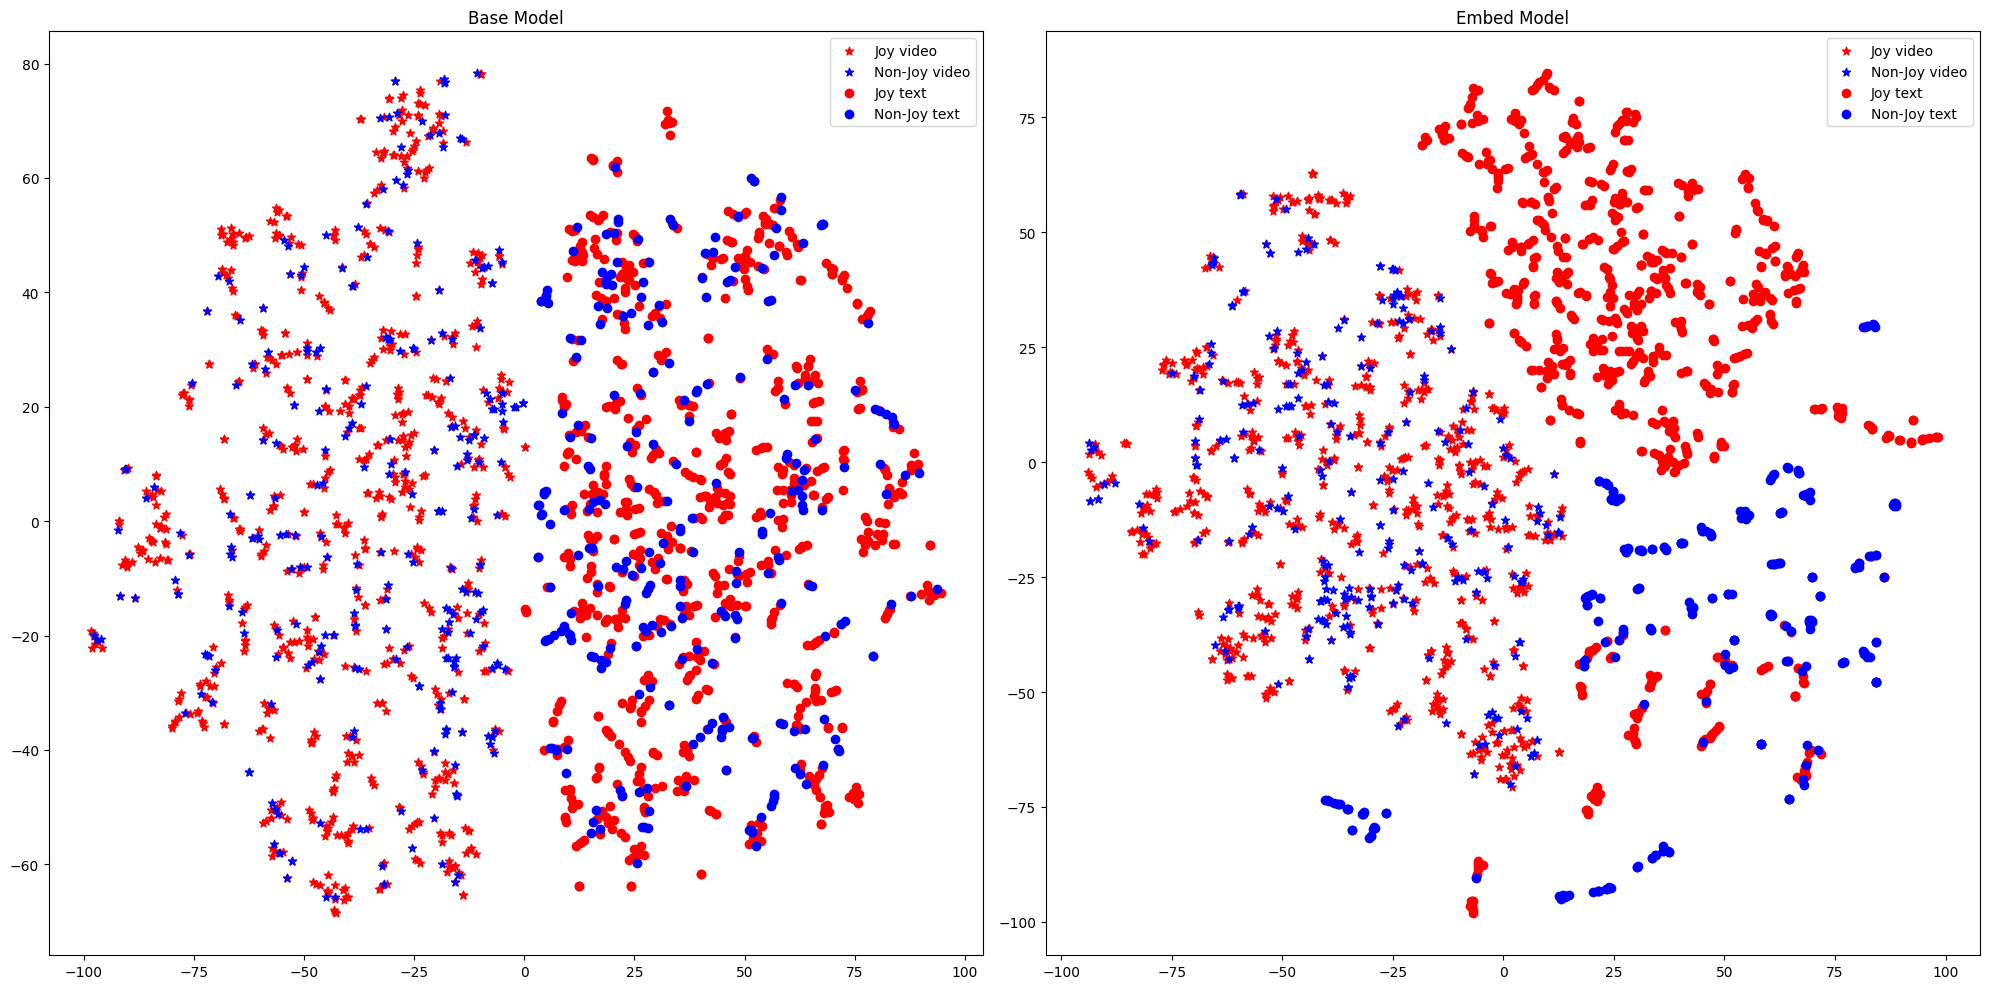

In [219]:
# visualize
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax.flatten()
ax[0].scatter(base_vis_tsne[joy_idx, 0], base_vis_tsne[joy_idx, 1], c='r', marker='*', label='Joy video')
ax[0].scatter(base_vis_tsne[joy_rest_idx, 0], base_vis_tsne[joy_rest_idx, 1], c='b', marker='*', label='Non-Joy video')
ax[0].scatter(base_text_tsne[joy_idx, 0], base_text_tsne[joy_idx, 1], c='r', marker='o', label='Joy text')
ax[0].scatter(base_text_tsne[joy_rest_idx, 0], base_text_tsne[joy_rest_idx, 1], c='b', marker='o', label='Non-Joy text')
ax[0].legend()
ax[0].set_title('Base Model')

ax[1].scatter(embed_vis_tsne[joy_idx, 0], embed_vis_tsne[joy_idx, 1], c='r', marker='*', label='Joy video')
ax[1].scatter(embed_vis_tsne[joy_rest_idx, 0], embed_vis_tsne[joy_rest_idx, 1], c='b', marker='*', label='Non-Joy video')
ax[1].scatter(embed_text_tsne[joy_idx, 0], embed_text_tsne[joy_idx, 1], c='r', marker='o', label='Joy text')
ax[1].scatter(embed_text_tsne[joy_rest_idx, 0], embed_text_tsne[joy_rest_idx, 1], c='b', marker='o', label='Non-Joy text')
ax[1].legend()
ax[1].set_title('Embed Model')
plt.tight_layout()
plt.show()